In [29]:
%%sh
pip install -q pip --upgrade
pip install -q sagemaker --upgrade --user

## Download the Fashion-MNIST dataset

In [34]:
import os
import numpy as np
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_val, y_val) = fashion_mnist.load_data()

os.makedirs("./data", exist_ok = True)
np.savez('./data/training', image=x_train, label=y_train)
np.savez('./data/validation', image=x_val, label=y_val)

In [3]:
!pygmentize fmnist.py

#!/usr/bin/env python3
import os, argparse
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import multi_gpu_model
import keras.backend as K

print ('Keras ', keras.__version__)

# Process command-line arguments
parser = argparse.ArgumentParser()

parser.add_argument('--epochs', type=int, default=10)
parser.add_argument('--learning-rate', type=float, default=0.01)
parser.add_argument('--batch-size', type=int, default=128)

parser.add_argument('--gpu-count', type=int, default=os.environ['SM_NUM_GPUS'])
parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
parser.add_argument('--training', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
parser.add_argument('--val

## Upload Fashion-MNIST data to S3

In [64]:
import sagemaker

print(sagemaker.__version__)

sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
prefix = 'keras2-fashion-mnist'

# upload('data/training.npz', 's3://{}/{}/input/training'.format(bucket, prefix))
training_input_path = sess.upload_data('data/training.npz', key_prefix=prefix+'/training')
validation_input_path = sess.upload_data('data/validation.npz', key_prefix=prefix+'/validation')
output_path = 's3://{}/{}/output/'.format(bucket, prefix)
chk_path = 's3://{}/{}/checkpoints/'.format(bucket, prefix)

print(training_input_path)
print(validation_input_path)
print(output_path)
print(chk_path)

1.60.2


'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.
'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.


s3://sagemaker-eu-west-1-613904931467/keras2-fashion-mnist/training/training.npz
s3://sagemaker-eu-west-1-613904931467/keras2-fashion-mnist/validation/validation.npz
s3://sagemaker-eu-west-1-613904931467/keras2-fashion-mnist/output/
s3://sagemaker-eu-west-1-613904931467/keras2-fashion-mnist/checkpoints/


## Train with Tensorflow on a GPU instance

In [76]:
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(entry_point='fmnist-1.py',
                          role=role,
                          train_instance_count=1, 
                          train_instance_type='ml.p3.2xlarge',
                          framework_version='2.1.0', 
                          py_version='py3',
                          hyperparameters={'epochs': 20},
                          output_path=output_path,
                          train_use_spot_instances=True,
                          train_max_run=3600,                    
                          train_max_wait=7200,
                          checkpoint_s3_uri=chk_path
                         )

In [77]:
tf_estimator.fit({'training': training_input_path, 'validation': validation_input_path})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-06-03 07:12:42 Starting - Starting the training job...
2020-06-03 07:12:44 Starting - Launching requested ML instances......
2020-06-03 07:13:49 Starting - Preparing the instances for training......
2020-06-03 07:15:12 Downloading - Downloading input data
2020-06-03 07:15:12 Training - Downloading the training image......
2020-06-03 07:16:06 Training - Training image download completed. Training in progress..2020-06-03 07:16:10,496 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-06-03 07:16:10,913 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training",
        "validation": "/opt/ml/input/data/validation"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "model_dir": "s3://s

ERROR:root:'NoneType' object has no attribute 'write'
2020-06-03 07:16:25.688938: W tensorflow/python/util/util.cc:319] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /opt/ml/checkpoints/fmnist-cnn-0011/assets
INFO:tensorflow:Assets written to: /opt/ml/checkpoints/fmnist-cnn-0011/assets
#015  128/60000 [..............................] - ETA: 35:50 - loss: 0.1297 - accuracy: 0.9453#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

INFO:tensorflow:Assets written to: /opt/ml/checkpoints/fmnist-cnn-0012/assets
INFO:tensorflow:Assets written to: /opt/ml/checkpoints/fmnist-cnn-0012/assets
#015  128/60000 [..............................] - ETA: 5s - loss: 0.1531 - accuracy: 0.9375#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1152/60000 [..............................] - ETA: 3s - loss: 0.1489 - accuracy: 0.9479#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

INFO:tensorflow:Assets written to: /opt/ml/checkpoints/fmnist-cnn-0015/assets
INFO:tensorflow:Assets written to: /opt/ml/checkpoints/fmnist-cnn-0015/assets
#015  128/60000 [..............................] - ETA: 10s - loss: 0.1136 - accuracy: 0.9609#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1024/60000 [..............................] - ETA: 4s - loss: 0.1438 - accuracy: 0.9502 #010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015  128/60000 [..............................] - ETA: 10s - loss: 0.1181 - accuracy: 0.9609#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  896/60000 [..............................] - ETA: 4s - loss: 0.1330 - accuracy: 0.9531 #010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1920/60000 [..............................] - ETA: 3s - loss: 0.1176 - accuracy: 0.9609#010#010#010#0


2020-06-03 07:17:12 Uploading - Uploading generated training modelINFO:tensorflow:Assets written to: /opt/ml/checkpoints/fmnist-cnn-0019/assets
INFO:tensorflow:Assets written to: /opt/ml/checkpoints/fmnist-cnn-0019/assets
#015  128/60000 [..............................] - ETA: 8s - loss: 0.1199 - accuracy: 0.9375#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1024/60000 [..............................] - ETA: 3s - loss: 0.1008 - accuracy: 0.9629#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#


2020-06-03 07:17:43 Completed - Training job completed
Training seconds: 169
Billable seconds: 51
Managed Spot Training savings: 69.8%


## Deploy

In [23]:
import time

tf_endpoint_name = 'keras-tf-fmnist-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

tf_predictor = tf_estimator.deploy(
                 initial_instance_count=1, 
                 instance_type='ml.m5.large',
                 endpoint_name=tf_endpoint_name)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-----------!

## Predict 

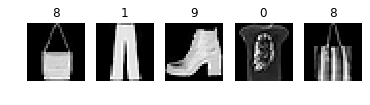

In [24]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(x_val.shape[0] - 1), num_samples)
images = x_val[indices]/255
labels = y_val[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')

payload = images.reshape(num_samples, 28, 28, 1)

In [25]:
# Default format for inference is JSON

from sagemaker.predictor import json_serializer
tf_predictor.content_type = 'application/json'
tf_predictor.serializer =  json_serializer

In [26]:
response = tf_predictor.predict(payload)
prediction = np.array(response['predictions'])
predicted_label = prediction.argmax(axis=1)
print('Predicted labels are: {}'.format(predicted_label))

Predicted labels are: [8 1 9 0 8]


## Clean up

In [27]:
tf_predictor.delete_endpoint()